# 🕵️ Fraud Busters: Credit Fraud Detection and Imbalanced Datasets

In this project, we'll be building a classification model that aims to detect fraud in credit card transactions. This type of task can get particularly tricky because the target variable is often extremely imbalanced. There may only be one fraud transaction out of the many thousands or millions of transactions, and we have to be able to pick them out. There are multiple methods in which we can deal with this imbalance, and we'll look into them one by one in this notebook. Without further ado, let's begin!

# Modules

First, let's import the modules that we'll be using in this notebook.

In [3]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_recall_fscore_support
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

# Dataset

Next, let's take a look at the data we have at hand.

In [4]:
credit_card = pd.read_csv("../data/creditcard.csv")
credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset that we have today consists of 31 variables, including our target variable: `Class`. This variable takes on two values, `0` as *Not Fraud* and `1` as *Fraud*. The remaining variables consist of `Time`, `Amount` and 28 *V variables*. The *V variables* are the results of a **PCA** (**Principal Component Analysis**) transformation in order to protect customer information. For those who are unfamiliar with PCA, it is, in essence, a dimensionality reduction technique that is able to reduce the number of dimensions while retaining the most important features. So you can think of these 28 *V variables* as a representation of a much larger number of different variables (like customer particulars, transaction amount, transaction location, etc.).  Since we don't have the specific data on what the *V variables* represent, we wouldn't be able to present a very interpretable result. Rather, we'll focus on the methods and evaluations we can adopt to deal with imbalanced datasets.

Anyways, let's take an approximate look at the distribution of each variable.

In [5]:
credit_card.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can see that only `Time` and `Amount` have drastically different scales from the other variables. We'll have to scale them later.

# Exploratory Data Analysis (EDA)

Before we do anything, let's perform a basic EDA on the three variables that are still interpretable.

## Target Variable: `Class`

<Axes: xlabel='Class', ylabel='count'>

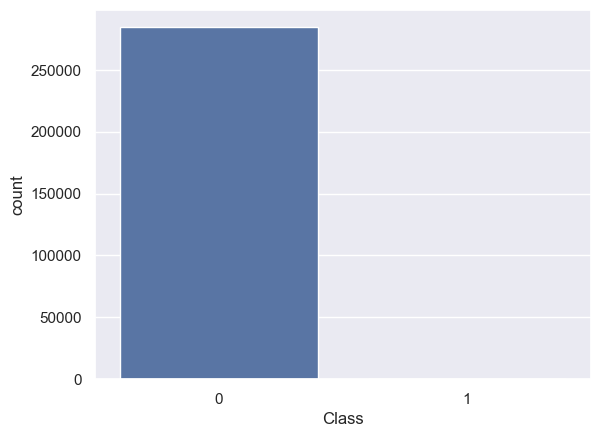

In [6]:
sns.countplot(x=credit_card["Class"])

In [7]:
credit_card["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

From the count plot, we can observe the extreme imbalance between the two classes of our target variable. This dataset is an accurate reflection of a real-world dataset. Obviously, most credit card transactions are not going to be fraud.

## `Time` and `Amount`

<Axes: xlabel='Time', ylabel='Count'>

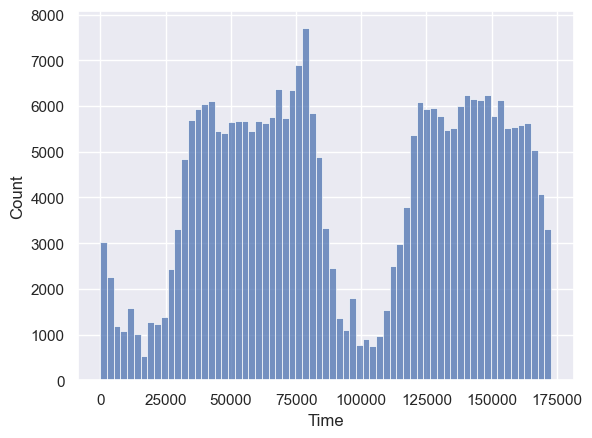

In [8]:
sns.histplot(data=credit_card, x="Time")

<Axes: xlabel='Amount', ylabel='Count'>

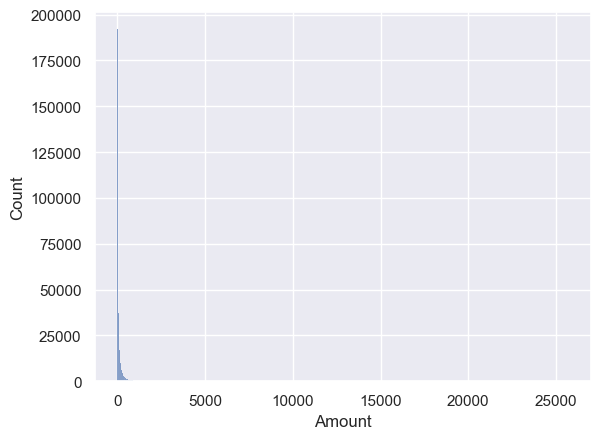

In [9]:
sns.histplot(data=credit_card, x="Amount", bins=500)

For `Time` and `Amount`, we'll plot them using a histogram since they're both numerical variables. We can also see that both distributions are quite weirdly shaped, with `Amount` being especially skewed to the right. It's important that we have to transform them later.

# Train-Test-Split

But before we jump in to process the data, let's split the data into training and testing.

In [10]:
y = credit_card.Class
X = credit_card.drop('Class', axis=1)

#split so that the proportions of imbalance remains the same in the training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

We'll split the training and testing dataset such that the proportions of class `1` and class `0` are the same in both the training and testing dataset. This will ensure that our model evaluations are accurate.

In [11]:
#training dataset proportion
y_train.value_counts(normalize=True)

Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

In [12]:
#testing dataset proportion
y_test.value_counts(normalize=True)

Class
0    0.998276
1    0.001724
Name: proportion, dtype: float64

# Data Preprocessing

Next, let's scale `Time` and `Amount`. We'll be using the `PowerTransfomer` to help us automatically scale and normalize the two variables.

<Axes: xlabel='Amount_scaled', ylabel='Count'>

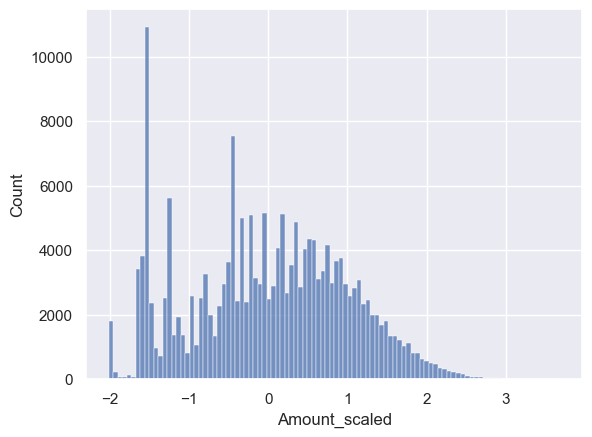

In [13]:
#instantiate power transformer
pt_amount = PowerTransformer()

#transform amount 
X_train['Amount_scaled'] = pt_amount.fit_transform(X_train['Amount'].values.reshape(-1,1))
sns.histplot(data=X_train, x="Amount_scaled", bins=100)

<Axes: xlabel='Time_scaled', ylabel='Count'>

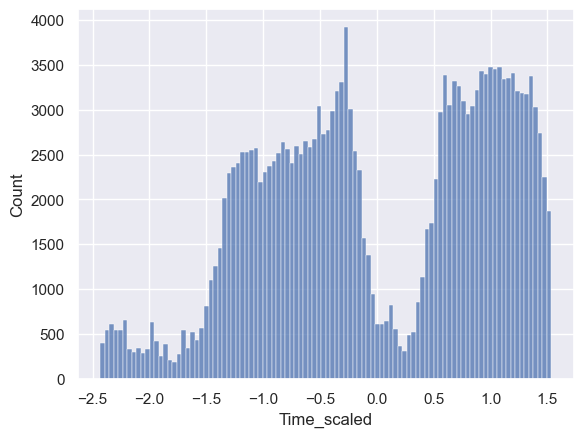

In [14]:
#instantiate power transformer
pt_time = PowerTransformer()

#transform time
X_train['Time_scaled'] = pt_time.fit_transform(X_train['Time'].values.reshape(-1,1))
sns.histplot(data=X_train, x="Time_scaled", bins=100)

With the scaled `Time_scaled` and `Amount_scaled` in our dataset, we can now safely remove the original `Time` and `Amount` out of our dataframe.

In [15]:
#drop origianl time and amount
X_train = X_train.drop(['Time', 'Amount'], axis=1)
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled,Time_scaled
198687,1.974025,-1.240696,-0.537317,-0.919764,-1.085459,-0.265272,-0.974899,0.039702,-0.140586,0.840128,...,0.038919,-0.085885,0.272160,-0.422904,-0.534651,-0.487102,-0.004465,-0.040389,0.840660,0.799759
129694,1.151280,-0.067410,1.274530,1.348017,-1.024868,-0.211370,-0.591920,0.118255,0.964253,-0.187955,...,-0.067541,-0.012958,0.001064,0.382891,0.398440,-0.407721,0.069214,0.037420,-0.429427,-0.262668
204218,2.076327,0.042540,-1.803333,0.385207,0.401630,-0.735175,0.072287,-0.120261,0.716797,-0.345200,...,-0.385648,-1.066798,0.342803,0.280876,-0.298808,0.191718,-0.068979,-0.035671,-1.271088,0.847982
134361,0.951966,-1.002169,0.649152,0.089675,-1.505037,-0.869371,-0.330709,-0.275044,-0.912232,0.619807,...,-0.035766,0.021394,-0.168223,0.784533,0.254052,0.615930,-0.031235,0.060012,1.291711,-0.229212
173252,-0.418134,-0.093914,0.306298,-2.548619,0.683397,-0.302791,0.554178,-0.103122,-0.808220,0.563669,...,-0.064795,-0.081516,0.115211,0.220057,-0.426465,-0.610719,0.093378,-0.027043,-0.718495,0.586599


Perfect! Next, we can apply the `PowerTransformer` to our testing dataset as well. The reason we apply transformation to the testing dataset after the training dataset is to prevent **data leakage**. Remember, we have to treat the testing dataset like we never knew about it during the training stage.

In [16]:
#transform Amount and Time for testing data
X_test['Amount_scaled'] = pt_amount.transform(X_test['Amount'].values.reshape(-1,1))
X_test['Time_scaled'] = pt_time.transform(X_test['Time'].values.reshape(-1,1))

X_test = X_test.drop(['Time', 'Amount'], axis=1)

Awesome! Now that we've performed some basic data preprocessing, let's move on to experiment with different methods of dealing with imbalanced data.

# ⚖️ Dealing with Imbalanced Data

Imbalanced datasets are a pain to deal with. The most famous treatment for imbalanced dataset is probably **SMOTE**, which stands for **Synthetic Minority Oversampling TEchnique**. It deals with imbalanced data by generating synthetic samples of the minority class based on the characteristics of its existing samples. Other sampling methods like **Oversampling** and **Undersampling** could also potentially work to solve imbalanced datasets. We'll look into each of these one-by-one. But before we conduct any sampling techniques, why not take a look at the different models we can use? Some models intrinsically perform better with imbalanced data than others. Typically, tree-based and boosting algorithms perform better with imbalanced data. Boosting models are especially ideal as higher weight is given to the minority class at each iteration. 

## Good for Imbalanced Dataset
- Decision Tree
- Random Forest
- Adaboost
- Gradient Boosting

## Bad for Imbalanced Dataset
- Logistics Regression
- Support Vector Classifier
- Naives Bayes

# Logistics Regression

Let's start by building a logistic regression model as our baseline model. How would this supposedly weak-performing model do?

Logistics Regression Accuracy:  0.9991807377616053


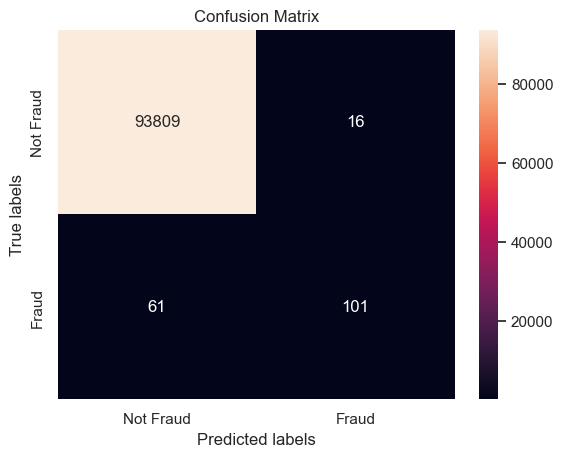

In [17]:
#build logistics regression model
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, y_pred)
print("Logistics Regression Accuracy: ", log_reg_accuracy)

#create confusion matrix
cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

Wow! Would you look at that accuracy! 99.9%! Who said logistic regression models sucked at predicting imbalanced classes? Okay, let's take a step back. Don't be misguided by the high accuracy. In normal classification tasks, we're motivated to aim for higher accuracy. But in extremely imbalanced datasets, accuracy is a flawed metric. Why? Because as long as the classification model classifies every sample as the majority class, the model would achieve high accuracy. But this destroys the whole purpose! The whole point of our task here is to identify the very few samples of the minority class, or in other words, detect the fraud transactions. So when dealing with imbalanced dataset, we have to look at other metrics. In most cases, we prefer to look at the **F-1 score**, which is the harmonic mean between **precision** and **recall**.

In [18]:
#print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.86      0.62      0.72       162

    accuracy                           1.00     93987
   macro avg       0.93      0.81      0.86     93987
weighted avg       1.00      1.00      1.00     93987



Based on the **confusion matrix** and **classification report** above, we can see that the logistics regression model achieved a **precision** of 0.86 and a **recall** of 0.62 for class 1. This means that while 86% of its fraud predictions were correct, it only captured 62% of the fraud transactions. In application, this recall may be too low. Our primary objective is to identify as much fraud transactions as possible.

# Precision-Recall Tradeoff

To identify more fraud transactions, what we could do is we could adjust the decision threshold for logistics regression. Each sample is assigned a probability (of it being fraud) by the logistic regression model. The decisive threshold is, by default, 0.5. We can lower that threshold so that more samples are predicted as *Fraud* (therefore capable of capturing more actual frauds).

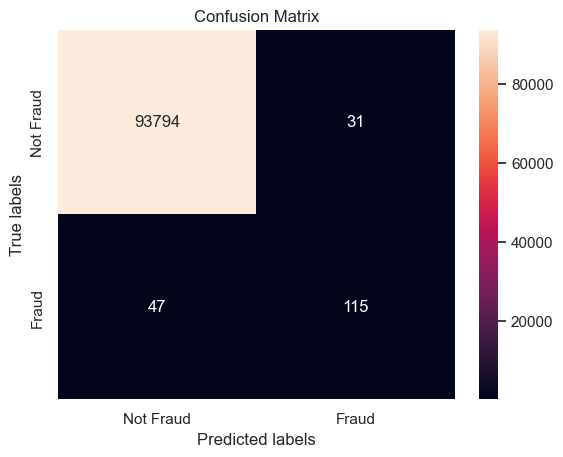

In [19]:
#change threshold to 0.2
y_pred_new = (log_reg.predict_proba(X_test)[:,1]>=0.2).astype(int)

#build confusion matrix
cm = confusion_matrix(y_test, y_pred_new)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [20]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.79      0.71      0.75       162

    accuracy                           1.00     93987
   macro avg       0.89      0.85      0.87     93987
weighted avg       1.00      1.00      1.00     93987



As we can see from above, by lowering the decision threshold to 0.2, we were able to increase our recall from 0.62 to 0.71, meaning we were able to capture an additional 9% of fraud transactions. This achievement, however, does not come without a cost. As we tried to predict more transactions as fraud, we also misclassified more non-fraud transactions as fraud, decreasing the precision (0.86 -> 0.79). Thus, we can observe a **trade-off relationship between precision and recall**.

We don't want either one of the value (precision and recall) to be too low, so we must strive for a balance between the two. Thankfully, that is exactly what **F-1 score** is designed to do. The **F-1 score** is the harmonic mean between recall and precision. So from now on, we will use F1-score as our main evaluation metric.

In the example of logistic regression, the F-1 score for a threshold=0.2 is greater than that of the default threshold (0.5). Therefore, if we were to use logistic regression as our model, it will be better to set the decision threshold at around 0.2.

# RandomForest

Next, let's try building models that are intrinisically better at dealing with imbalanced datasets. We'll start with the `RandomForestClassifier`.

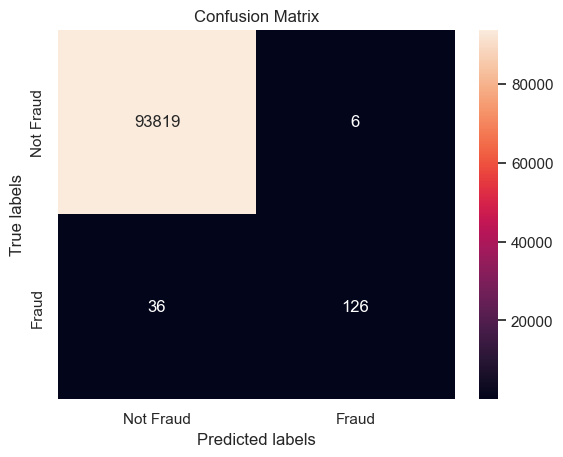

In [21]:
#build randomforest model
rfm = RandomForestClassifier(random_state=42)

rfm.fit(X_train, y_train)
rfm_pred = rfm.predict(X_test)

#build confusion matrix
rfm_cm = confusion_matrix(y_test, rfm_pred)

ax= plt.subplot()
sns.heatmap(rfm_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [22]:
print(classification_report(y_test, rfm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.95      0.78      0.86       162

    accuracy                           1.00     93987
   macro avg       0.98      0.89      0.93     93987
weighted avg       1.00      1.00      1.00     93987



Wow! We can see that `RandomForestClassifier` performed much better than logistics regression! The F-1 score is much higher. Also note that this model is being built without any tuning. We can definitely aim to improve this model.

# Adaboost

Let's also give the `AdaBoostClassifer` a shot.

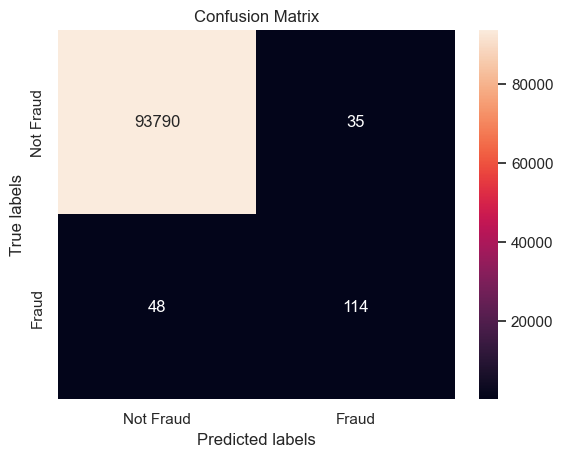

In [23]:
#build adaboost classifier
ada = AdaBoostClassifier(random_state=42)

ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

#build confusion matrix
ada_cm = confusion_matrix(y_test, ada_pred)

ax= plt.subplot()
sns.heatmap(ada_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [24]:
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.77      0.70      0.73       162

    accuracy                           1.00     93987
   macro avg       0.88      0.85      0.87     93987
weighted avg       1.00      1.00      1.00     93987



Turns out the `AdaboostClassifier` didn't perform very well in this particular case. We probably could improve the model's performance by tuning and playing around with the parameters, but `RandomForestClassifier` seems to be the better choice here.

# Gradient Boosting

We should also try the `GradientBoostingClassifier`, which is popular algorithm that has proven to be very successful in many tasks. 

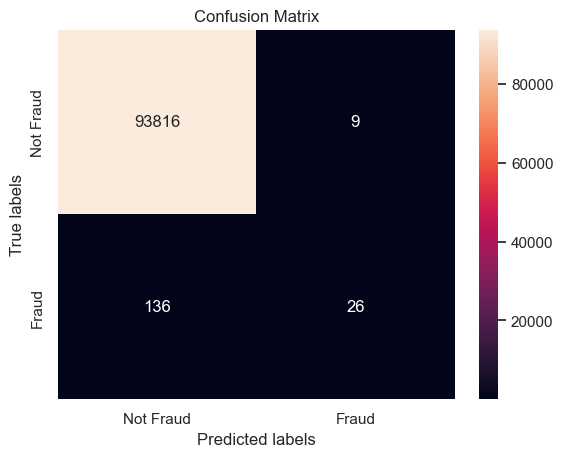

In [25]:
#build gradient boosting
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

#build confusion matrix
gb_cm = confusion_matrix(y_test, gb_pred)

ax= plt.subplot()
sns.heatmap(gb_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [26]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.74      0.16      0.26       162

    accuracy                           1.00     93987
   macro avg       0.87      0.58      0.63     93987
weighted avg       1.00      1.00      1.00     93987



Wow! `GradientBoosting` actually performed horribly! We can see that the F-1 score is super low. In fact, if we look at the confusion matrix, we see that the model is basically predicting all samples as *Not Fraud*.  But again, we haven't done any hyperparameter tunings yet, so that could be the issue here. Nonetheless, let's just resort to using the `RandomForestClassifier`.

# Sampling

Okay, now that we have a basic understanding of which algorithms tends to work better (without hyperparameter tuning), let's pull back to discuss about **sampling**. When we deal with imbalanced datasets, sampling could be the difference maker between a good model and an excellent model. The three most popular sampling methods are **oversampling**, **undersampling** and **SMOTE**. We will demonstrate and try all three to compare which method works out the best in our task.

One important thing to note is that when we resample our data, **we should only resample the training data and not the testing data**. Build your model using the resampled data and then test it with the untouched testing data. Although this note shouldn't come as a surprise, many people accidentally commit this mistake.

As we can see below, we start off with 190490 counts of class `0` and 330 counts of class `1` in our training data.

In [27]:
#double check the counts of 0 and 1s
y_train.value_counts()

Class
0    190490
1       330
Name: count, dtype: int64

We glue the X and y variables back together to reconstruct our dataframe and seperate it again by the `class`.

In [28]:
# concatenate our training data back together
X_concat = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X_concat[X_concat.Class==0]
fraud = X_concat[X_concat.Class==1]

## Oversampling

Now our data is ready to be resampled. We'll start by demonstrating **oversampling**. In essence, oversampling just refers to the the resampling of the minority class until its number of instances matches that of the majority class. This can easily be done with the `resample` function from `sklearn.utils`. Below, we can see that both classes now have 190490 samples. 

In [29]:
# oversample fraud transaction (minority)
fraud_oversampled = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=42) # with replacement

# combine majority and oversampled minority
oversampled = pd.concat([not_fraud, fraud_oversampled])

#split X and y
y_train_oversampled = oversampled.Class
X_train_oversampled = oversampled.drop('Class', axis=1)

# check new class counts
oversampled.Class.value_counts()

Class
0    190490
1    190490
Name: count, dtype: int64

## Undersampling

On the contrary, **undersampling** refers to the resampling of the majority class until its instances matches that of the minority class. Its implementation is the same as oversampling and we can see that both classes only contain 330 samples. 

In [30]:
# undersample not fraud (majority)
not_fraud_undersampled = resample(not_fraud, replace=False, n_samples=len(fraud), random_state=42) #without replacement

# combine undersampled majority and minority
undersampled = pd.concat([not_fraud_undersampled, fraud])

#split X and y
y_train_undersampled = undersampled.Class
X_train_undersampled = undersampled.drop('Class', axis=1)

# check new class counts
undersampled.Class.value_counts()

Class
0    330
1    330
Name: count, dtype: int64

Oversampling and undersampling are both very simple and straightforward methods to deal with imbalanced datasets. But they do have their own set of potential problems.

### Problems with Oversampling
The problem with oversampling is that it can lead to overfitting, where the model learns the noise and outliers in the minority class instead of the underlying patterns. This could lead to poor generalization and performance on unseen data.

### Problems with Undersampling
The problem with undersampling is that it can result in loss of information. Many instances from the majority class are discarded from the dataset and that could include essential underlying patterns. 

## SMOTE

The problems with oversampling and undersampling is the reason many resort to using SMOTE instead. SMOTE stands for Synthetic Minority Oversampling TEchnique. We briefly mentioned this method earlier and it basically generates new, original samples of the minority class based on its features (X variables). The implementation is super simple. We can just feed in our X and y training data into the `SMOTE` function from `imblearn.over_sampling`.

In [31]:
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

y_train_sm.value_counts()

Class
0    190490
1    190490
Name: count, dtype: int64

Would you look at that! The minority class now has 190490 samples. SMOTE is really just another variation of oversampling. That being said, SMOTE, of course, would inherit some of problems with oversampling.

### Problems with SMOTE
1. **Overfitting**: SMOTE can generate synthetic samples that are too similar to the existing minority class samples, leading to overfitting.
2. **Noise and Outliers**: SMOTE can also generate outliers or noisy synthetic samples, which could impact the model's performance.
3. **Curse of Dimensionality**: SMOTE can struggle with high-dimensional data since it relies on the distance between instances to generate synthetic samples. In high-dimensional space, the distance between instances becomes less meaningful.
4. **Extreme Imbalance**: SMOTE can be less effective when the imbalance gets too extreme. SMOTE may not be able to generate enough synthetic samples to balance the dataset.

# RFM with Oversampling

Awesome! Now that we've gone through the three sampling methods, let's apply each resample dataset to our `RandomForestClassifier` and see if it would lead to an improvment in performance. Let's start with oversampling.

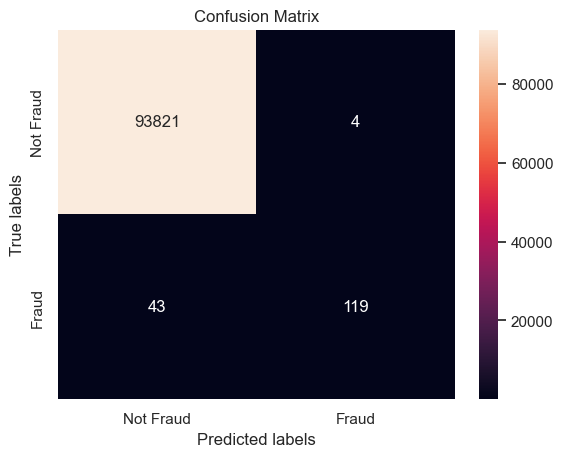

In [32]:
#RFM with oversampled data
rfm_OS = RandomForestClassifier(random_state=42)

rfm_OS.fit(X_train_oversampled, y_train_oversampled)
rfm_OS_pred = rfm_OS.predict(X_test)

#build confusion matrix
rfm_OS_cm = confusion_matrix(y_test, rfm_OS_pred)

ax= plt.subplot()
sns.heatmap(rfm_OS_cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [33]:
print(classification_report(y_test, rfm_OS_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.97      0.73      0.84       162

    accuracy                           1.00     93987
   macro avg       0.98      0.87      0.92     93987
weighted avg       1.00      1.00      1.00     93987



The results indicate that training the `RandomForestClassifier` on the oversampled data does not exceed the performance of the initial model. This could be due to the problems we discussed about oversampling.

# RFM with Undersampling

What about undersampling? Let's take a look.

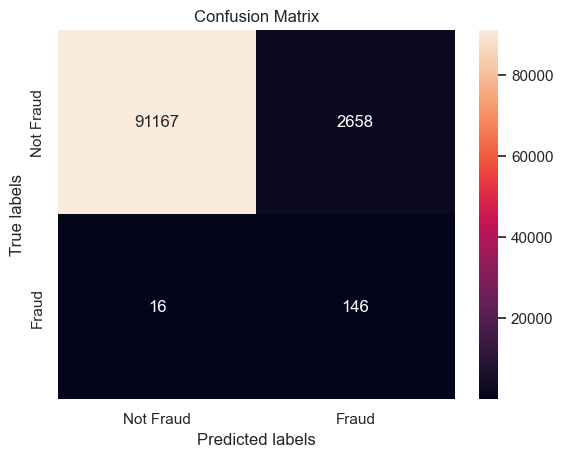

In [34]:
#RFM with undersampled data
rfm_US = RandomForestClassifier(random_state=42)

rfm_US.fit(X_train_undersampled, y_train_undersampled)
rfm_US_pred = rfm_US.predict(X_test)

#build confusion matrix
rfm_US_cm = confusion_matrix(y_test, rfm_US_pred)

ax= plt.subplot()
sns.heatmap(rfm_US_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [35]:
print(classification_report(y_test, rfm_US_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93825
           1       0.05      0.90      0.10       162

    accuracy                           0.97     93987
   macro avg       0.53      0.94      0.54     93987
weighted avg       1.00      0.97      0.98     93987



Oof! Undersampling seems to do even worse than oversampling. We can see that precision dropped to 0.05 in exchange for a relatively high recall at 0.90. This leads to a low f1-score. Although we were able to identify 90% of the fraud transactions, the predictions are not precise at all.

# RFM with SMOTE

Finally, we've arrived at our final resampling method, SMOTE. Will SMOTE bring the glory home?

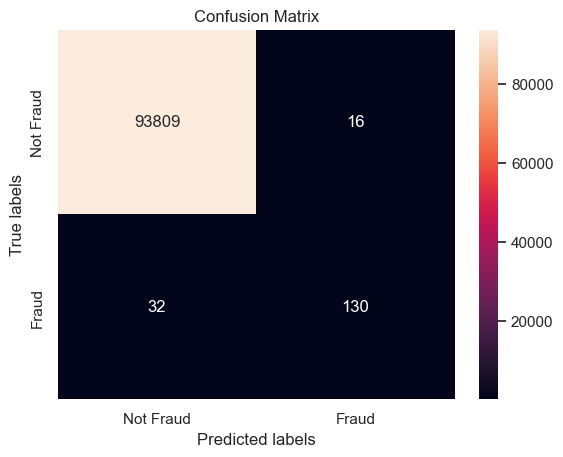

In [36]:
#RFM with SMOTE
rfm_sm = RandomForestClassifier(random_state=42)

rfm_sm.fit(X_train_sm, y_train_sm)
rfm_sm_pred = rfm_sm.predict(X_test)

#build confusion matrix
rfm_sm_cm = confusion_matrix(y_test, rfm_sm_pred)

ax= plt.subplot()
sns.heatmap(rfm_sm_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [37]:
print(classification_report(y_test, rfm_sm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.89      0.80      0.84       162

    accuracy                           1.00     93987
   macro avg       0.95      0.90      0.92     93987
weighted avg       1.00      1.00      1.00     93987



Hey, would you look at that! The results of using RFM with SMOTE is also pretty good. Although the F-1 score was not as high as the initial RF model (0.86), the recall is higher. This meant we were able to identify slightly more fraud transactions. In turn, the precision is still within acceptable range at 0.89, so not too bad!

# Hyperparameter Tuning

## `class_weight` for `RandomForestClassifier`

Finally, I want to bring your attention to a hyperparameter available in the `RandomForestClassifier`, `class_weight`, which could be helpful in dealing with imbalanced datasets. By default, the `RandomForestClassifer` assigns equal weight to each class (`class_weight=None`), which can result in poor performance in the minority class. Therefore, we could actually set `class_weight="balanced"` to adjust the class weights based on the inverse frequency of each class in the training set. A higher weight being assigned to the minority class means that the recall should improve (at the expense of the precision of course). You could even assign your own custom weights to each class by using a dictionary (eg. `class_weight={0:1, 1:5}` means that weight 1 is assigned to class 0 and weight 5 is assigned to class 1). Let's try this out!


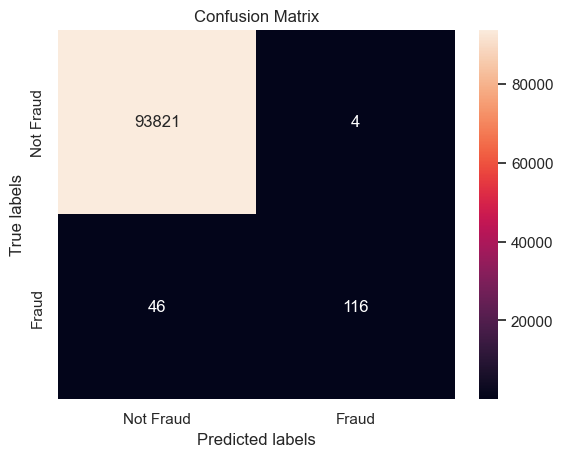

In [38]:
#RFM with SMOTE and balanced class_weight
rfm_sm_classWeightBalanced = RandomForestClassifier(class_weight = "balanced", random_state=42)

#feed in the training data without any resampling
rfm_sm_classWeightBalanced.fit(X_train, y_train)
rfm_sm_classWeightBalanced_pred = rfm_sm_classWeightBalanced.predict(X_test)

#build confusion matrix
rfm_sm_classWeightBalanced_cm = confusion_matrix(y_test, rfm_sm_classWeightBalanced_pred)

ax= plt.subplot()
sns.heatmap(rfm_sm_classWeightBalanced_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [39]:
print(classification_report(y_test, rfm_sm_classWeightBalanced_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.97      0.72      0.82       162

    accuracy                           1.00     93987
   macro avg       0.98      0.86      0.91     93987
weighted avg       1.00      1.00      1.00     93987



Oof! Theoretically, the recall for class 1 should improve by adjusting the `class_weight`, but it didn't. This could be due to many factors including insufficient data, model complexity, overfitting, etc. We may have to experiment this setting with other hyperparameters. But I'm an impatient man and I just can't stand waiting in front of my computer for `GridSearchCV` to find the optimal parameters. If you're reading this now, maybe you can try running `GridSearchCV`! Feel free to let me know which set of hyperparameters worked best for you! You'll make me a happy happy man <3.

# Model Comparison

Finally, let's put everything together to compare the different statistics of the five `RandomForestClassifiers` that we built.

In [42]:
#model dictionary
predicted_values = {"RandomForest": rfm_pred, 
                    "RandomForest OS": rfm_OS_pred, 
                    "RandomForest US": rfm_US_pred, 
                    "RandomForest SMOTE": rfm_sm_pred,
                    "RandomForest Balanced class_weight": rfm_sm_classWeightBalanced_pred}

#create df
df = pd.DataFrame(columns=['model', 'precision', 'recall', 'f1_score'])

#plug precision recall and f1score into the dataframe for each model
for key, value in predicted_values.items():
    precision = precision_recall_fscore_support(y_test, value, average=None)[0][1]
    recall = precision_recall_fscore_support(y_test, value, average=None)[1][1]
    f1_score = precision_recall_fscore_support(y_test, value, average=None)[2][1]
    df = pd.concat([df, pd.DataFrame([{'model': key, 'precision':precision, 'recall':recall, 'f1_score':f1_score}])], ignore_index=True)

df = df.set_index('model')
df.head()

/var/folders/_z/fqc2y1zs5nxfts7kcfj9y20w0000gn/T/ipykernel_44524/3308876365.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{'model': key, 'precision':precision, 'recall':recall, 'f1_score':f1_score}])], ignore_index=True)


,precision,recall,f1_score
model,,,
RandomForest,0.954545,0.777778,0.857143
RandomForest OS,0.967480,0.734568,0.835088
RandomForest US,0.052068,0.901235,0.098449
RandomForest SMOTE,0.890411,0.802469,0.844156
RandomForest Balanced class_weight,0.966667,0.716049,0.822695


Again, we can see that the f1_score is the highest for the initial `RandomForestClassifier` model (without any treatments to the imbalanced dataset). This model, however, has a relatively higher precision than its recall. In many cases of imbalanced dataset (like this with fraud detection), we should be willing to sacrifice some precision for better recall. Therefore, *RandomForest with SMOTE* also seems like a pretty good choice. *RandomForest US* would be way too extreme as it sacrificed way too much precision for a little increase in recall.

# ROC and AUC

Aside from recall, precision and *F1_score*, other metrics we often look at are the **ROC** (**Receiver Operating Characteristic**) and **AUC** (**Area under the ROC Curve**). The ROC curve maps out the relationship between **True Positive Rate** (**TPR**) and **False Positive Rate** (**FPR**). Let refresh our memory real quick.

* **True Positive Rate (sensitivity)**: Out of all fraud cases, the amount that is classified as fraud
* **False Positive Rate (1-specificity)**: Out of all non-fraud cases, the amount that is classified as fraud

From the definition of the two, it should be quite clear that we want to aim for a higher TPR and a lower FPR. But at the same time, a higher TPR would typically also lead to a higher FPR, so we have to strive for a balance. Let's plot out the ROC curve for all five our models.

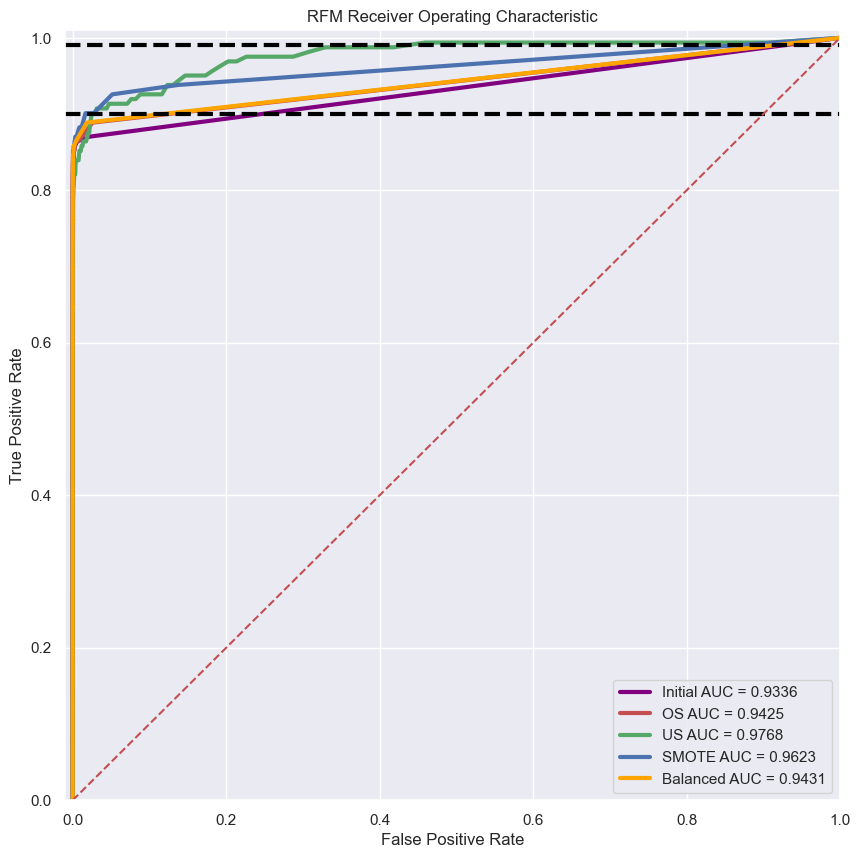

In [43]:
#change figure size
plt.figure(figsize=(10, 10))

#Initial RFM
rfm_probas = rfm.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'purple', linewidth=3, label = 'Initial AUC = %0.4f' % roc_auc)

#RFM Oversampled
rfm_OS_probas = rfm_OS.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_OS_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', linewidth=3, label = 'OS AUC = %0.4f' % roc_auc)

#RFM Undersampled
rfm_US_probas = rfm_US.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_US_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', linewidth=3, label = 'US AUC = %0.4f' % roc_auc)

# RFM SMOTE
rfm_sm_probas = rfm_sm.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_sm_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', linewidth=3, label = 'SMOTE AUC = %0.4f' % roc_auc)

#RFM with balanced class_weight 
rfm_sm_classWeightBalanced_probas = rfm_sm_classWeightBalanced.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_sm_classWeightBalanced_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'orange', linewidth=3, label = 'Balanced AUC = %0.4f' % roc_auc)

#plot horizontal line at y=0.9 and y=0.99
plt.axhline(y=0.9, color = 'black', linestyle='dashed', linewidth=3)
plt.axhline(y=0.99, color = 'black', linestyle='dashed', linewidth=3)

plt.title('RFM Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

From the ROC curve, it becomes easy to visualize the relationship between TPR and FPR. Now, we have to ask ourselves the question "What is the minimum TPR that we're willing to accept?". We can see that if we can accept a TPR of 0.9 (90% of all fraud captured), then *RF with SMOTE* (blue line) may be the best model because its FPR was the lowest out of all when its TPR reached 0.9 (bottom dashed horizontal line). But if we want to achieve a TPR of 0.99 (99% of all fraud captured), then *RF with Undersampling* is the best (top dashed horizontal line). 

A metric that generalizes the overall performance is the AUC. Out of all five models, *RF with Undersampling* stood out with the best AUC, so some may argue that this is the best model. And to a certain degree, I kind of have to agree. If we want to achieve a high TPR (identifying as much actual fraud as possible), the *RF with Undersampling* model beats the other by the quite the margin, which is also why its AUC is the greatest. On the contrary, the initial RandomForest model seem to perform the worst in terms of AUC. This was something we weren't able to capture when evaluating the recall, precision and F-1 score.

Finally, before we conclude, I also want to remind that in the case of an imbalanced dataset, even a FPR of just 0.2 means a very low precision. This is due to the extreme difference in the majority and minority class. We can see this being the case for *RF with Undersampling*.

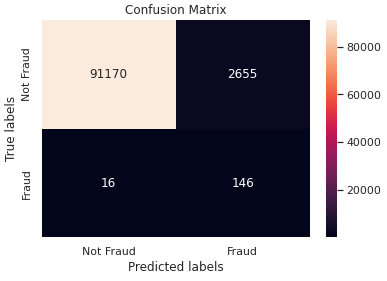

Above we have the confusion matrix for *RF with Undersampling*. The FPR is only 0.03 here (2555/(91170+2555)), but we can see that the precision is already super low. A small portion of the majority class could still be huge when compared to the minority class. This means that if we wanted to achieve a TPR of 99%, even if we used *RF with Undersampling*, the model that maintained the lowest FPR (~0.3), that FPR of ~0.3 would mean a huge number of non-fraud transactions being classified as fraud. Therefore, we have to consider whether this super low precision is really worth it just to identify that extra one or two fraud transactions.

# Conclusion

Wow! We discussed a lot in this notebook. Let's recap. 

- imbalanced datasets are hard to deal with
- some models are intrinisically better at dealing with imbalanced datasets
- resampling is a common treatment to deal with imbalanced datasets
- resample only the training data, not the testing data
- accuracy is a horrible evaluation metric, instead look for f1_score, precision and recall (and maybe ROC and AUC)

Phew! My brain is about to explode just from writing this. The models we built in this notebook could definitely be improved further with hyperparameter tuning, so try it out if you have time! Hope you enjoyed this notebook and was able to take away something from it. If you like this work, please upvote!